# Bayesian PCA

PCA provides a way to reduce the effective dimensionality of a dataset by exploiting correlations between dimensions with the data. If we record data from 5 sensors, and each of those sensors records 10 measurements, we have a dataset of d=5 and N=10. Some of the sensors may record similar or highly correlated information and it can be useful (especially if the number of measurements or the number of sensors (dimensions) is high) to convert the data to a different format with fewer dimensions, i.e. reduce the dimensionality. PCA does just this by orthogonalizing the dimensions of the data (decorrelating each dimension from the other dimensions). If the original data has strong correlations, then some of the dimensions after PCA will have little or no variance and can be discarded. The one caution is that data from different sensors often come with different variances to begin with. So, one dimension could have a low variance relative to the other dimensions but still be extremely important with respect to the information that it transmits. Sometimes, it's best to Z-score the data or perform some other type of manipulation in order to normalize the variances of each dimension.

Bayesian PCA will provide a nice way to reduce the effective dimensionality of a dataset automatically. First, a probabilistic PCA model provides a probability model for Bayesian techniques. The data, x, is expressed in a latent variable model, x = Wz+u+epsilon. P(x) = N(x|u,C), where C is a covariance matrix given by C = WW'+sigmasquareI, and sigmasquare is the variance of independent gaussian noise. So, if C is a full-rank d-by-d matrix, W can be expressed as d-by-(d-1) and still provide a full-rank representation of C. If, however, we want to reduce the dimensionality of the covariance representation, we can set W to be size d-by-q. Bayesian model selection allows us to choose a value between 1 and d-1 for the effective dimensionality of W automatically. Then, we can represent the covariance matrix in reduced form. The technique places a multivariate Gaussian prior with variance = 1/alpha-i on each column (i) of W. This prior automatically drives dimensions with low variance to zero in the matrix W.

## Traditional PCA

In [15]:
load hald
% always best to subtract out the mean first
mu = mean(ingredients,1); % mean along each dimension
data = bsxfun(@minus,ingredients,mu);
[coeff,score,latent,~,~,~] = pca(data);

[N,d] = size(ingredients); % D for number of dimensions
reconstructedData = score*coeff'+repmat(mu,N,1);

fprintf('Original Data\n\n');
display(ingredients);

fprintf('Reconstructed data as suggested by MATLAB\n\n');
display(reconstructedData);

data = data';size(data)
% pca is just taking the eigenvalue decomposition of the covariance matrix
[V,D] = eig(cov(data')); % won't necessarily order the eigenvalues like
          % matlab's pca function does
% V is now the exact same thing as coeff above
%  the pca approximation of a data vector is the following
dataVector = data(:,1); % mean has been subtracted already
summation = 0;
for ii=1:d
    summation = summation+(dataVector'*V(:,ii)-zerosMu'*V(:,ii))*V(:,ii);
end
% the zerosMu is not necessary, just to show that it's there if mu does not equal zero

pcaApprox = mu'+summation;
% this is trivial if we use all of the eigenvectors, but very helpful
%  and memory/computation efficient if we use only some of the eigenvectors

fprintf('Reconstructed first measurement via eig(cov)\n\n');
display(pcaApprox');

Original Data

ingredients =
     7    26     6    60
     1    29    15    52
    11    56     8    20
    11    31     8    47
     7    52     6    33
    11    55     9    22
     3    71    17     6
     1    31    22    44
     2    54    18    22
    21    47     4    26
     1    40    23    34
    11    66     9    12
    10    68     8    12
Reconstructed data as suggested by MATLAB

reconstructedData =
    7.0000   26.0000    6.0000   60.0000
    1.0000   29.0000   15.0000   52.0000
   11.0000   56.0000    8.0000   20.0000
   11.0000   31.0000    8.0000   47.0000
    7.0000   52.0000    6.0000   33.0000
   11.0000   55.0000    9.0000   22.0000
    3.0000   71.0000   17.0000    6.0000
    1.0000   31.0000   22.0000   44.0000
    2.0000   54.0000   18.0000   22.0000
   21.0000   47.0000    4.0000   26.0000
    1.0000   40.0000   23.0000   34.0000
   11.0000   66.0000    9.0000   12.0000
   10.0000   68.0000    8.0000   12.0000
ans =
     4    13
Reconstructed first measurement

Maintaining the full dimensionality in "score", or keeping all of the eigenvectors, you can easily recover the original data. 

# Dimensionality Reduction

In [20]:
% as recommended by MATLAB
fprintf('MATLAB PCA Reconstruction\n\n');
reduceCoeff = coeff(:,1:3);
reduceScore = score(:,1:3);
dimReduceReconstructedData = reduceScore*reduceCoeff'+repmat(mu,N,1);

display(ingredients);

display(dimReduceReconstructedData);

avError = mean(mean(abs(ingredients-dimReduceReconstructedData)));
fprintf('Average absolute error in reconstruction of original data: %3.2f\n',avError);

avRelError = mean(mean(abs(ingredients-dimReduceReconstructedData)./ingredients));
fprintf('Average relative error in reconstruction of original data: %3.3f\n',avRelError);

% another way to do the same thing
pcaApprox = zeros(d,N);

for ii=1:N
  summation = 0;
  for jj=2:d
      summation = summation+(data(:,ii)'*V(:,jj))*V(:,jj);
  end
  pcaApprox(:,ii) = mu'+summation;
end

fprintf('Bishop''s PCA Reconstruction\n\n');
display(pcaApprox');

MATLAB PCA Reconstruction

ingredients =
     7    26     6    60
     1    29    15    52
    11    56     8    20
    11    31     8    47
     7    52     6    33
    11    55     9    22
     3    71    17     6
     1    31    22    44
     2    54    18    22
    21    47     4    26
     1    40    23    34
    11    66     9    12
    10    68     8    12
dimReduceReconstructedData =
    6.7992   25.8043    5.7955   59.8079
    1.2004   29.1953   15.2041   52.1918
   11.5700   56.5555    8.5806   20.5455
   11.1916   31.1867    8.1952   47.1834
    6.9279   51.9298    5.9266   32.9310
   11.0683   55.0666    9.0696   22.0654
    2.9586   70.9597   16.9578    5.9604
    0.8358   30.8400   21.8328   43.8429
    2.2752   54.2682   18.2803   22.2634
   20.8276   46.8320    3.8244   25.8351
    0.7797   39.7854   22.7756   33.7892
   10.7738   65.7796    8.7696   11.7836
    9.7917   67.7970    7.7878   11.8006
Average absolute error in reconstruction of original data: 0.20
Average 

The recovered data is almost identical to the original. Thus, the reduceScore and pcaApprox matrices are lower-dimensional representations of the original data.

# Probabilistic PCA

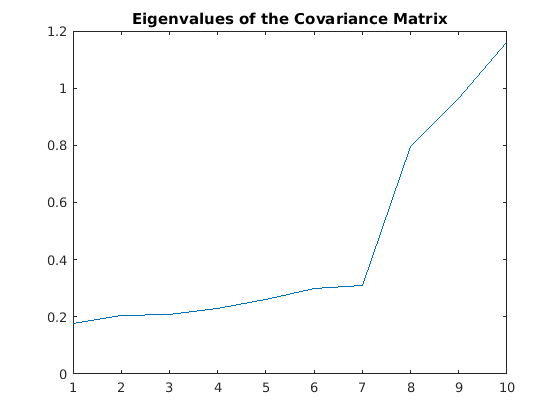

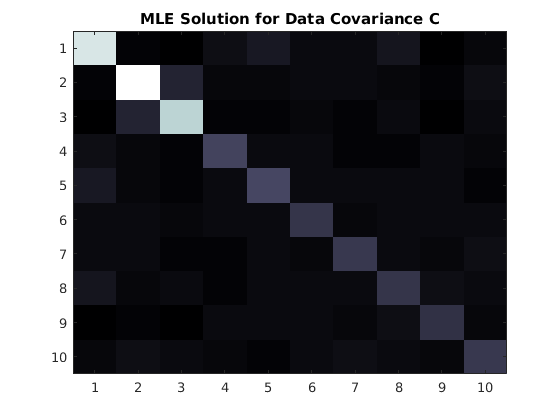

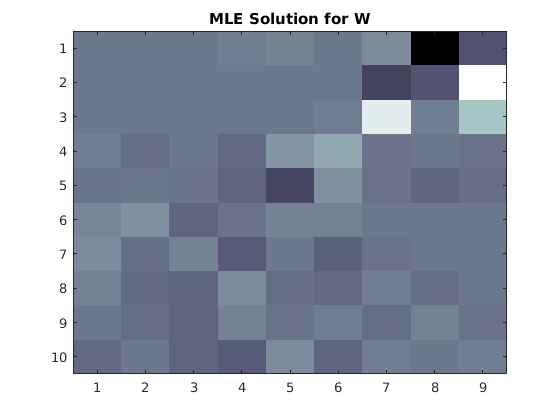

In [24]:
% GENERATE DATA WITH 3 DIMENSIONS OF VARIANCE 1 and 7 DIMENSIONS OF VARIANCE 0.5
N = 300;d = 10;
q = d-1;
data = zeros(d,N);
for ii=1:N
    for jj=1:3
        data(jj,ii) = normrnd(0,1);
    end
end
for ii=1:N
    for jj=4:d
        data(jj,ii) = normrnd(0,0.5);
    end
end

dataMu = mean(data,2);
data = data-repmat(dataMu,[1,N]);
S = cov(data');% (1/(N-1))*data*data';
[V,D] = eig(S);
trueW = V(:,2:end)*sqrtm(D(2:end,2:end)-D(1,1)*eye(q));
trueC = trueW*trueW'+D(1,1)*eye(d);

figure();imagesc(trueW);colormap('bone');title('MLE Solution for W');
figure();imagesc(trueC);colormap('bone');title('MLE Solution for Data Covariance C');

figure();plot(diag(D));title('Eigenvalues of the Covariance Matrix');

The figures will be used for comparison later. From each, it's clear that 3 dimensions are dominating. In this case, we would probably use the three eigenvectors with the largest eigenvalues to make a lower-dimensional representation of the data.

# PPCA (cont.)

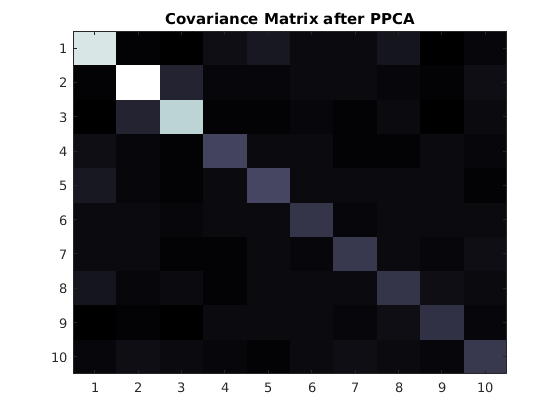

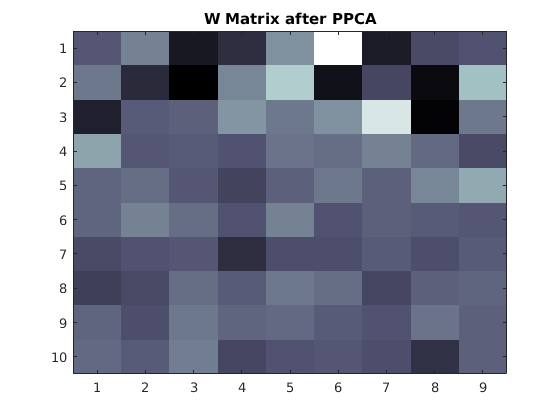

In [26]:
q = 9;
W = normrnd(0,1,[d,q]);
% W = V(:,2:end)*sqrtm(D(2:end,2:end)-D(1,1)*eye(q));
sigmasquare = var(data(:))/2;

expectedMean = zeros(q,N);
expectedCov = zeros(q,q,N);
results = zeros(5000,1);
%  100 iterations is more than enough for this data
for iter=1:5000
    prevW = W;
    M = W'*W+sigmasquare.*eye(q);
    Minv= inv(M);
    expectedMean = Minv*W'*data;
    for jj=1:N
       expectedCov(:,:,jj) = sigmasquare.*Minv+(expectedMean(:,jj)*expectedMean(:,jj)');
    end
    
    W = (data*expectedMean')*inv(sum(expectedCov,3));
    
    sigmasquare = 0;
    for jj=1:N
       sigmasquare = sigmasquare+norm(data(:,jj),'fro')^2-2*(expectedMean(:,jj)')*(W')*data(:,jj)+...
           trace(squeeze(expectedCov(:,:,jj))*(W')*W);
    end
    sigmasquare = sigmasquare./(N*d);
    results(iter) = sum(abs(prevW(:)-W(:)));
    if iter>5 && results(iter)<1e-5
       break; 
    end
end
figure();imagesc(W);colormap('bone');title('W Matrix after PPCA');
% subplot(2,1,2);plot(results);title('Model Fit for Probabilistic PCA');
% xlabel('Iteration');ylabel('Error');
figure();imagesc(W*W'+sigmasquare*eye(d));colormap('bone');title('Covariance Matrix after PPCA');

Here, we have evaluated W not using the maximum likelihood estimator but, rather, using the EM algorithm. It doesn't look the same as W above, but it still remains a full-rank and exact representation of the covariance matrix C (as long as we know sigmasquare as well). We can make lower-rank representations of C by choosing q to be less than d-1.

# Bayesian PCA

Recall that the goal of Bayesian PCA is to automatically determine the appropriate number of dimensions to maintain. In this case, we know that 7 dimensions have a lower variance than the remaining three, so we should probably discard those dimensions if we're worried about computation time or saving memory, etc (with the caveat that we have to be careful of what I said above, i.e. certain dimensions may low variance and yet still carry a lot of information).

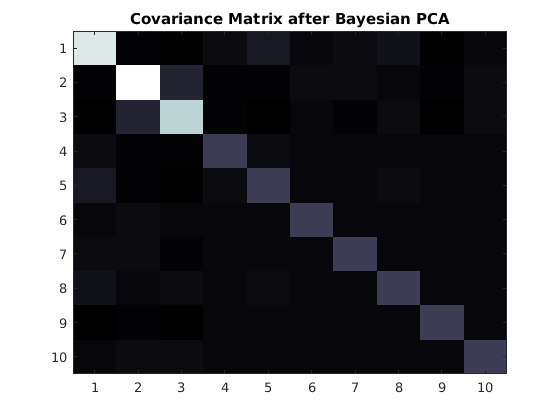

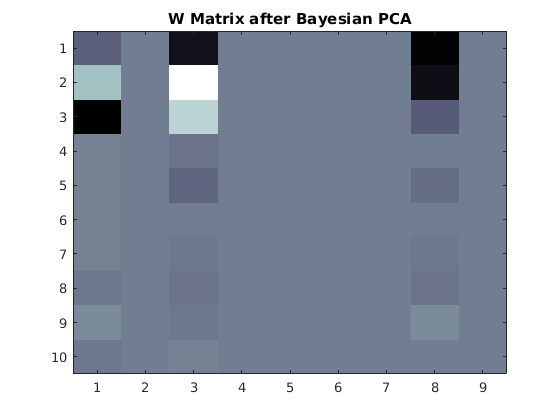

In [28]:
warning('off','all'); % the matrix W will become singular so matlab throws an error
W = normrnd(0,1,[d,q]);
% W = V(:,2:end)*sqrtm(D(2:end,2:end)-D(1,1)*eye(q));
alpha = zeros(q,1);
for jj=1:q
   alpha(jj) = d/(W(:,jj)'*W(:,jj)); % d./diag(W'*W);
end

results = zeros(5000,1);
for iter=1:5000
    prevW = W;
    M = W'*W+sigmasquare.*eye(q);
    Minv= inv(M);
    expectedMean = Minv*W'*data;
    for jj=1:N
       expectedCov(:,:,jj) = sigmasquare.*Minv+(expectedMean(:,jj)*expectedMean(:,jj)');
    end
    A = diag(alpha);
    W = (data*expectedMean')*inv(sum(expectedCov,3)+sigmasquare.*A);
    
    for jj=1:q
        alpha(jj) = d/(W(:,jj)'*W(:,jj));
    end
    
    sigmasquare = 0;
    for jj=1:N
       sigmasquare = sigmasquare+norm(data(:,jj),'fro')^2-2*(expectedMean(:,jj)')*(W')*data(:,jj)+...
           trace(squeeze(expectedCov(:,:,jj))*(W')*W);
    end
    sigmasquare = sigmasquare./(N*d);
    results(iter) = sum(abs(prevW(:)-W(:)));
    if iter>5 && results(iter)<1e-5
       break; 
    end
end
figure();imagesc(W);colormap('bone');title('W Matrix after Bayesian PCA');
% subplot(2,1,2);plot(results);title('Model Fit for Bayesian PCA');
% xlabel('Iteration');ylabel('Error');
figure();imagesc(W*W'+sigmasquare*eye(d));colormap('bone');
title('Covariance Matrix after Bayesian PCA');

Because of the random initializations, W is not the same here as above. However, it has successfully and automatically shut off 6 of the columns of W, leaving us with 3 dimensions. In practice,  you can check which columns of W contain all zeroes and then create a smaller matrix for W. Using W to recreate the covariance matrix, we see that it's essentially identical to those above. If the dataset is relatively small, then we can initialize Bayesian PCA with the MLE solution (W = V(:,2:end)sqrtm(D(2:end,2:end)-D(1,1)eye(q))), which will make it go faster.

In [36]:
% if we wish to invert C, we can do so in the lower-dimensional space as follows
%  (1/sigmasquare)M is the latent-space covariance matrix
newW = [];
for ii=1:q
    if sum(abs(W(:,ii))) > 1e-5
        newW = [newW,W(:,ii)];
    end
end
newQ = size(newW,2);
M = newW'*newW+sigmasquare*eye(newQ);
Cinv = (1/sqrt(sigmasquare))*eye(d)-(1/sigmasquare)*newW*inv(M)*newW';

% we can get our latent-space (pca space) representation as follows
z = inv(M)*newW'*(data(:,1)); % as long as mean has been subtracted

fprintf('Original, mean-subtracted data\n');
display(data(:,1));

% and we can get back to normal space by 
pcaApprox = newW*z;
display(pcaApprox);

Original, mean-subtracted data
    0.4123
   -1.6310
    0.2688
   -0.3442
    0.7970
   -0.7863
    0.1766
   -0.7462
   -0.3495
   -0.5357
pcaApprox =
    0.3478
   -1.2407
    0.1102
    0.0190
    0.0424
   -0.0227
   -0.0082
    0.0303
   -0.0036
   -0.0206


The pca approximation does fairly poorly for the remaining 7 dimensions because those were, in this case, independent Gaussian components. The reduced-dimensionality representation gets the first three dimensions (which it preserved through the covariance matrix) pretty well considering we now have a representation of the 10-by-10 covariance matrix with a matrix of size 10-by-3.